In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

from sa_decomp_layer import SADecompLayer

import tensorflow as tf
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import matplotlib.pyplot as plt
import numpy as np
#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K


from tensorflow.keras.layers import Layer
from tensorflow.image import flip_up_down, flip_left_right, rot90
from tensorflow.compat.v1 import extract_image_patches
import numpy as np

from keras.layers import Conv2D, Dense, Flatten, MaxPool2D
from keras.models import Sequential, load_model


In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def get_filter(layer):
    layer = model.layers[layer]

    # check for convolutional layer
    if 'conv' not in layer.name:
        return None
    # get filter weights
    filters, biases = layer.get_weights()
    return (filters)
    #print(layer.name, filters.shape)


In [101]:
def SADecomp(filters, asym=False):
    inputs_shape = tf.shape(filters)  
        
    #height, width, n_channel, n_filters = inputs_shape[0], inputs_shape[1], inputs_shape[2], inputs_shape[3]
    k = filters.shape[0]
    exp_data  = tf.expand_dims(filters[0], 0)


    #patches = extract_image_patches(filters, [1, k, k, 1],  [1, k, k, 1], rates = [1,1,1,1] , padding = 'VALID')
    #print(patches)
    mat_flip_x = np.fliplr(filters)

    mat_flip_y = np.flipud(filters)

    mat_flip_xy =  np.fliplr( np.flipud(filters))

    sum = filters + mat_flip_x + mat_flip_y + mat_flip_xy
    mat_sum_rot_90 = np.rot90(sum)

    #gc.collect()
    #print("mat_sum_rot_90 shape " , mat_sum_rot_90.shape, self._name)
    
    #print("OUT SHAPE," , out.shape)
    if asym:
        return  filters - ((sum + mat_sum_rot_90) / 8)
    return  (sum + mat_sum_rot_90) / 8

In [34]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

import os
import cv2
import numpy as np
#https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

def load_img(img_path,img_shape, preprocess=True):
    
    img_rows=img_shape[0]
    img_cols=img_shape[1]
    #num_channel=img_shape[2]


    img = image.load_img(img_path , target_size=(img_rows, img_cols))    
    if preprocess:
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)

        img =  preprocess_input(img)
        return img

    #data = np.array(data)
    #data = data.astype('float32')
    #data /= 255
    #labels=np.array(labels)
    #print('data shape',data.shape)
    #print('labels shape',labels.shape)
    return np.array(img)

#### 1. Get VGG filters

In [14]:
f = get_filter(1)

In [8]:
f.shape[-1]

64

#### 2. Get Symetric Component of fitlers


In [15]:
f_sym = SADecomp(f[:,:,:,0][0])

In [16]:
f_sym

array([[0.19574507, 0.3127517 , 0.19574508],
       [0.3127517 , 0.44007453, 0.3127517 ],
       [0.19574508, 0.3127517 , 0.19574508]], dtype=float32)

In [61]:
f[:,:,:,0][0]

array([[ 0.42947057,  0.55037946,  0.4800154 ],
       [ 0.373467  ,  0.44007453,  0.4085474 ],
       [-0.06136011, -0.08138704, -0.06514555]], dtype=float32)

(3, 3, 3)
3
[[ 0.42947057  0.373467   -0.06136011]
 [ 0.27476987  0.03868078 -0.36722335]
 [-0.05746817 -0.26224968 -0.35009676]]
[[-0.00986362  0.00469096 -0.00986362]
 [ 0.00469096  0.03868078  0.00469096]
 [-0.00986362  0.00469096 -0.00986362]]
3
[[ 0.55037946  0.44007453 -0.08138704]
 [ 0.34573907  0.04063221 -0.4535013 ]
 [-0.05863491 -0.33066967 -0.4850302 ]]
[[-0.01866817  0.00041065 -0.01866817]
 [ 0.00041065  0.04063221  0.00041065]
 [-0.01866817  0.00041065 -0.01866817]]
3
[[ 0.4800154   0.4085474  -0.06514555]
 [ 0.31047726  0.05020237 -0.40338343]
 [-0.05087169 -0.2852275  -0.41851634]]
[[-0.01362954  0.00760343 -0.01362954]
 [ 0.00760343  0.05020237  0.00760343]
 [-0.01362954  0.00760343 -0.01362954]]


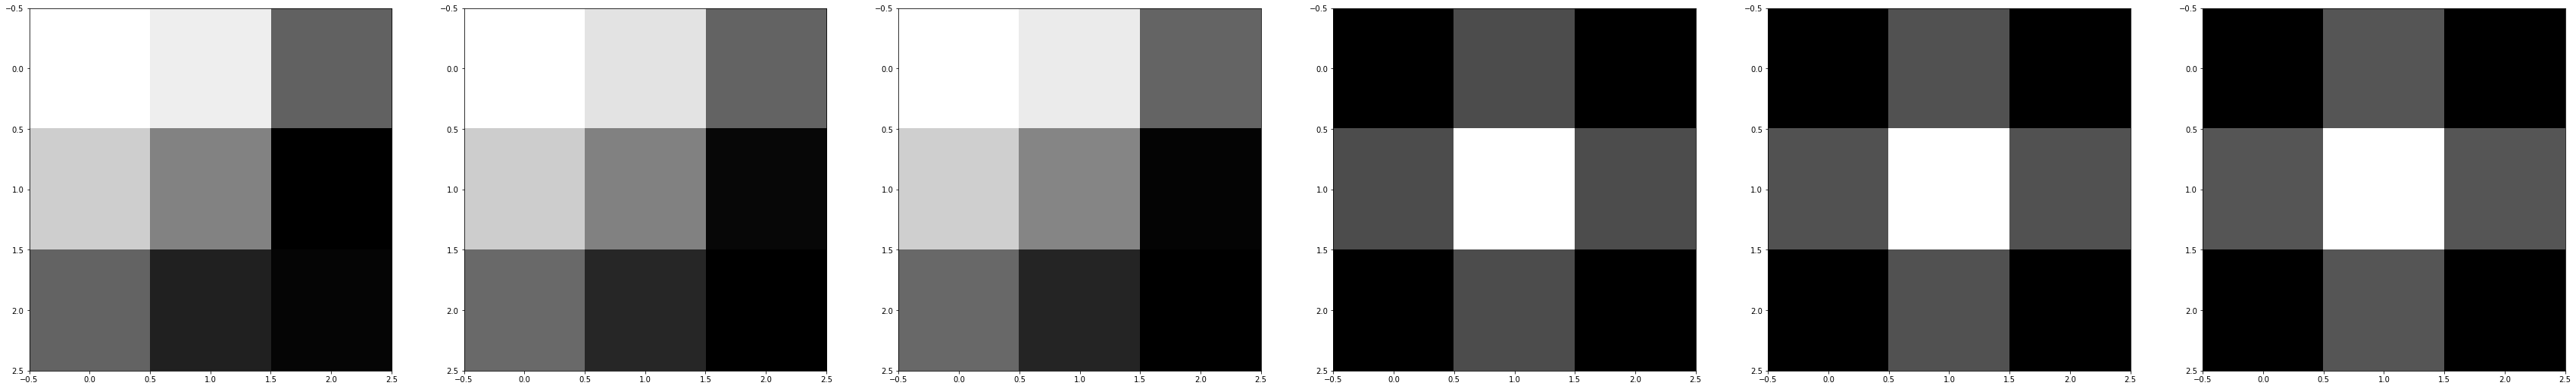

In [88]:
fig = plt.figure(figsize=(60, 60))

columns = 6
rows = 1


filters = get_filter(1)
for i in range(1):
    filter = filters[:,:,:, i]
    print(filter.shape)
    for j in range(filter[:,:, j].shape[-1]):
        f = filter[:,:, j]
        print(filter[:,:, j].shape[-1])
        print(f)
        fig.add_subplot(rows,columns, j+1)
        plt.imshow(f, cmap=plt.get_cmap('gray'))

        f_sym = SADecomp(f)
        print(f_sym)

        fig.add_subplot( rows,columns, j+4)
        plt.imshow(f_sym, cmap=plt.get_cmap('gray'))

plt.show()

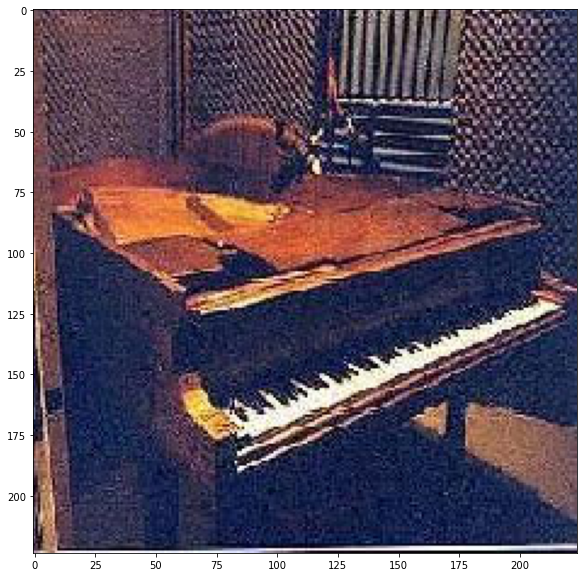

In [120]:

img = load_img("../Caltech256/test/091.grand-piano-101/091_0080.jpg", [224,224,3], preprocess=False)
plt.imshow(img)

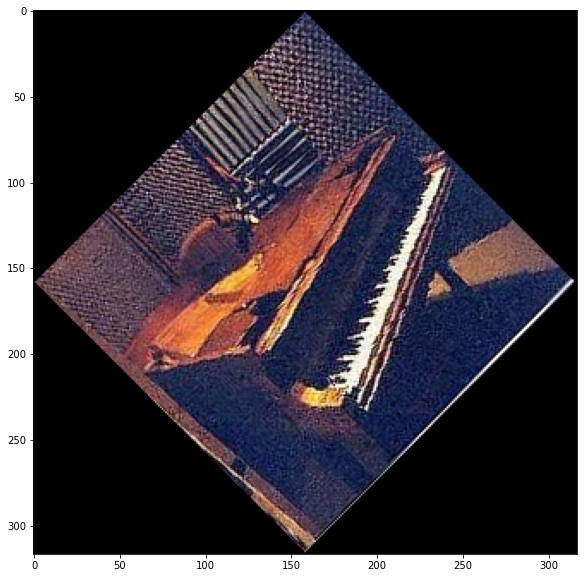

In [121]:
img_rot = ndimage.rotate(img, 45)
plt.imshow(img_rot)

#### 3. Conv sym filters with input


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


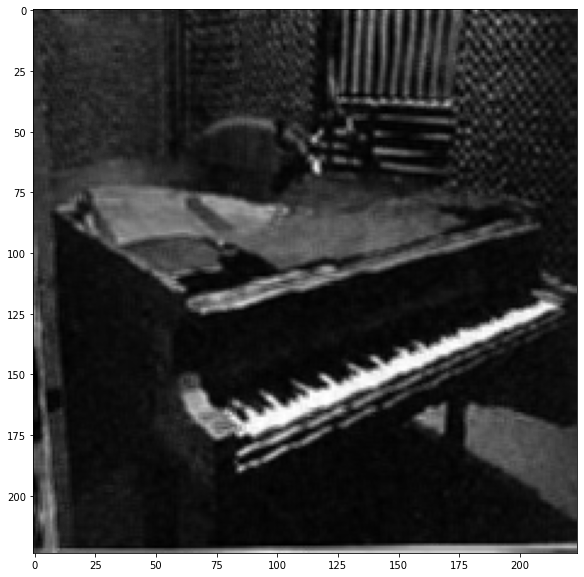

In [124]:
fig = plt.figure(figsize=(10, 10))

columns = 1
rows = 5


filters = get_filter(1)
out = np.zeros((224,224))
for i in range(filters.shape[-1]):
    print(i)
    filter = filters[:,:,:,i]
    img_out = np.zeros((224,224))
    for j in range(filter[:,:, j].shape[-1]):
        f = filter[:,:, j]
        #fig.add_subplot(rows,columns, j+1)
        #plt.imshow(f, cmap=plt.get_cmap('gray'))
        f_sym = SADecomp(f, asym=False)
        img_out += cv2.filter2D(img[:,:,j], -1, f_sym)
        #print(f_sym)
    out += img_out ** 2


plt.imshow(out, cmap=plt.get_cmap('gray'))



In [117]:
img_rot.shape[:-1]

(317, 317)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


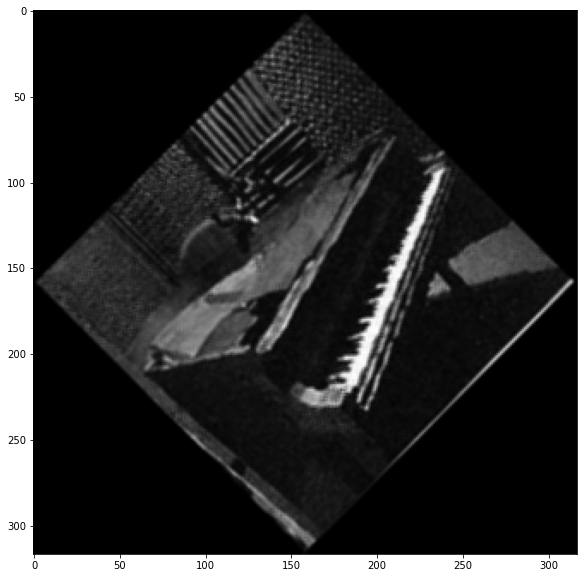

In [125]:
fig = plt.figure(figsize=(10, 10))

columns = 1
rows = 5


filters = get_filter(1)
out = np.zeros(img_rot.shape[:-1])
for i in range(filters.shape[-1]):
    print(i)
    filter = filters[:,:,:,i]
    img_out = np.zeros(img_rot.shape[:-1])
    for j in range(filter[:,:, j].shape[-1]):
        f = filter[:,:, j]
        #fig.add_subplot(rows,columns, j+1)
        #plt.imshow(f, cmap=plt.get_cmap('gray'))
        f_sym = SADecomp(f, asym=False)
        img_out += cv2.filter2D(img_rot[:,:,j], -1, f_sym)
        #print(f_sym)
    out += img_out ** 2


plt.imshow(out, cmap=plt.get_cmap('gray'))